In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

# Fonctions SW/GradSW et données Image

In [2]:
def SWgrad(u,v,nbProj):#Pour deux images de même taille
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    Res = np.zeros((N,M,d))
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        for j in range(N*M):
                Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
        
    Res = Res*2/nbProj
    
    return Res

def SW(u,v,nbProj):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    SW = 0
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
    SW = SW/nbProj
    
    return SW

def SW_gradSW(u,v,nbProj):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    SW = 0
    gradSW = np.zeros((N,M,d))
    
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        
        for j in range(N*M):
                gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    SW = SW/nbProj
    
    return SW, gradSW

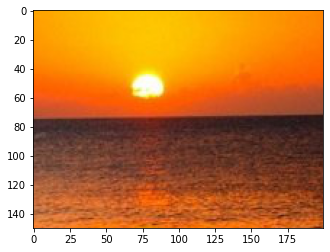

In [3]:
I1 = plt.imread('../data/coucher.jpg')
Xtrue = I1[100:250, 450:650, :]/255
plt.imshow(Xtrue)

In [4]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out  

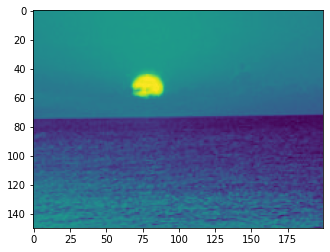

In [5]:
L_M = spectrale_degradation(Xtrue, 1, 3, 0)
plt.imshow(L_M)

In [6]:
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

In [7]:
L_H = spatial_degradation(Xtrue, 2, 0)

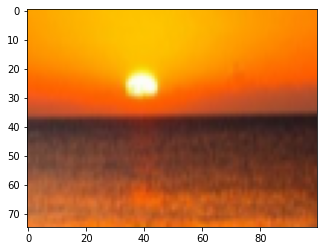

In [8]:
plt.imshow(L_H)

In [9]:
def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

In [10]:
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [11]:
def PSNR(reference, reconstruct):
    mse = np.mean((reference - reconstruct) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [12]:
def aSAM(reference, reconstruct):
    N = reference.shape[0]
    M = reference.shape[1]
    asam = 0
    for j in range(N*M):
        ps = np.dot(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)].transpose())
        norm = np.linalg.norm(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])*np.linalg.norm(reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])
        asam = asam + np.arccos(ps/norm)
    asam = asam/(N*M)
    return asam

In [13]:
def acSSIM(reference, reconstruct):
    l = reference.shape[2]
    acssim = 0
    for i in range(l):
        acssim = acssim + skimage.metrics.structural_similarity(reference[:,:,i], reconstruct[:,:,i])
    acssim = 1 - acssim/l
    return acssim    

# Descente de gradient avec visualisation des normes indépendantes 

In [14]:
def gradientDescente_pasConstant(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, nbProj)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, nbProj)
    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    Gradient_quad = 2*(X-reech_interp(L_H, K_ech))
    
    Fct = [Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2]
    SW_Z1 = [Lbd_SW1*SW1]
    SW_Z2 = [Lbd_SW2*SW2]
    NormeL2 = [mu*L2]
    
    
    Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
    Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad
    X = X - pas*grad

    
    nu = 10**-4
    
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, nbProj)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, nbProj)
    
    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))
    Gradient_quad = 2*(X-reech_interp(L_H, K_ech))

    
    Fct.append(Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2)
    SW_Z1.append(Lbd_SW1*SW1)
    SW_Z2.append(Lbd_SW2*SW2)
    NormeL2.append(mu*L2)
    
    Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
    Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad

    
    i = 1
    while(np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > nu and i <10000):
        X = X - pas*grad
        
        SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, nbProj)
        SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, nbProj)
        L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))
        Gradient_quad = 2*(X-reech_interp(L_H, K_ech))

        Fct.append(Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2)
        SW_Z1.append(Lbd_SW1*SW1)
        SW_Z2.append(Lbd_SW2*SW2)
        NormeL2.append(mu*L2)

        Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
        Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
        grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad

        #if(i%10 == 0):
        print( 'iter = ', i , "fonction = ", Fct[i])

        i = i+1
    
    return X, Fct, SW_Z1, SW_Z2, NormeL2

In [74]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 1, 1, 3, 0.2)

iter =  1 fonction =  590.3302054809731
iter =  2 fonction =  166.87225225246817
iter =  3 fonction =  59.77019306869661
iter =  4 fonction =  20.030370757967454
iter =  5 fonction =  10.909088758278504
iter =  6 fonction =  6.482822113981047
iter =  7 fonction =  3.671965402798303
iter =  8 fonction =  2.4039192933956173
iter =  9 fonction =  1.6675022029363025
iter =  10 fonction =  1.2843533415272381
iter =  11 fonction =  1.117765977504952
iter =  12 fonction =  1.0356572235422528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


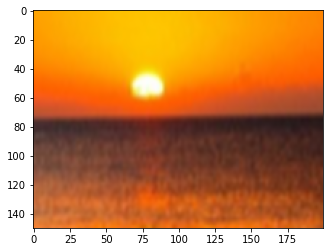

In [75]:
plt.imshow(X)

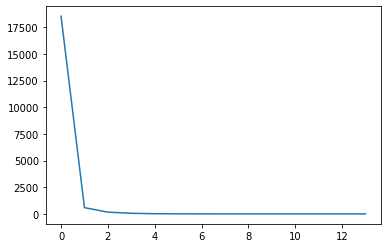

In [76]:
plt.plot(Fct)

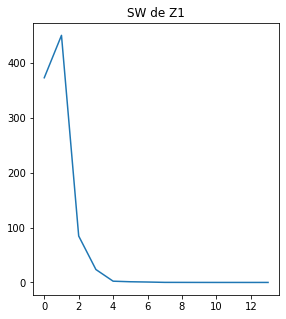

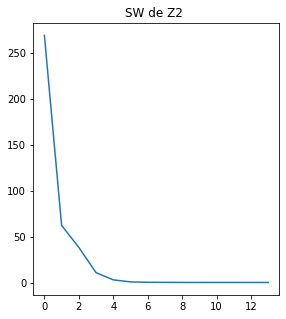

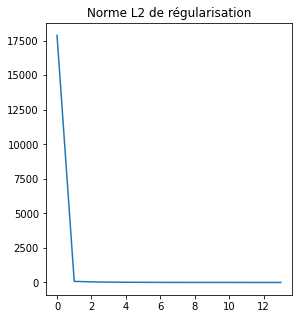

In [77]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

# Calcul des normes pour Xtrue

In [78]:
SW1, Gradient1 = SW_gradSW(spatial_degradation(Xtrue, 2, 0), L_H, 5)
SW2, Gradient2 = SW_gradSW(spectrale_degradation(Xtrue, 1, 3, 0), L_M, 5)
L2 = np.linalg.norm(Xtrue-reech_interp(L_H, 2))**2
Fonctionnelle = SW1 + SW2 + L2

In [79]:
print("Valeur de la Fonctionnelle pour image de base : ", Fonctionnelle)
print("Valeur de la SW1 pour image de base : ", SW1)
print("Valeur de la SW2 pour image de base : ", SW2)
print("Valeur de la norme L2 pour image de base : ", L2)

Valeur de la Fonctionnelle pour image de base :  66.4154530684852
Valeur de la SW1 pour image de base :  0.0
Valeur de la SW2 pour image de base :  0.0
Valeur de la norme L2 pour image de base :  66.4154530684852


# Descente avec pondération des SW

In [80]:
difference = 0
for i in range(len(SW_Z1)):
    difference = difference + SW_Z1[i]/SW_Z2[i]
difference = difference/len(SW_Z1)

In [81]:
print("Le ratio moyen entre la SW1 et la SW2 est : ", difference)

Le ratio moyen entre la SW1 et la SW2 est :  1.2711138406750673


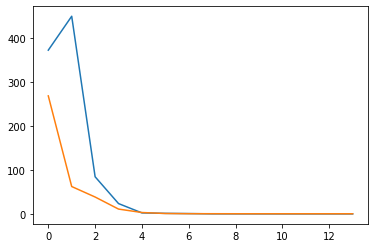

In [82]:
plt.plot(SW_Z1)
plt.plot(SW_Z2)
plt.show()

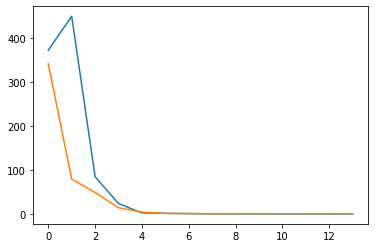

In [83]:
plt.plot(SW_Z1)
plt.plot(np.array(SW_Z2)*difference)
plt.show()

In [84]:
Lbd_1 = 1
Lbd_2 = difference

In [85]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, Lbd_1, Lbd_2, 1, 5, 0.2)

iter =  1 fonction =  384.8013686354994
iter =  2 fonction =  129.12201296576663
iter =  3 fonction =  49.410475838163464
iter =  4 fonction =  20.556294017806458
iter =  5 fonction =  10.208313300379377
iter =  6 fonction =  5.669616658034965
iter =  7 fonction =  3.4535349703129863
iter =  8 fonction =  2.2634983310490773
iter =  9 fonction =  1.6663069269755517
iter =  10 fonction =  1.3592619962174046
iter =  11 fonction =  1.2368942936741076
iter =  12 fonction =  1.1937990479150473
iter =  13 fonction =  1.1709672204022736
iter =  14 fonction =  1.2017819757673054
iter =  15 fonction =  1.184711168889335
iter =  16 fonction =  1.1654320309782595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


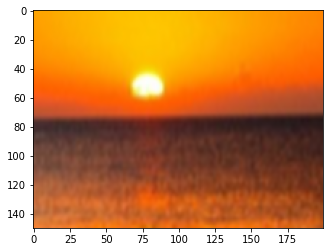

In [88]:
plt.imshow(X)

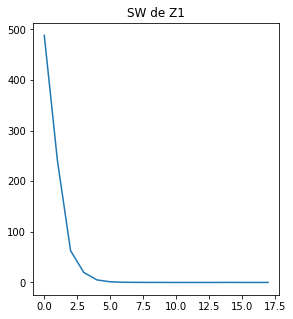

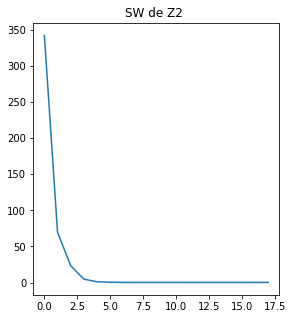

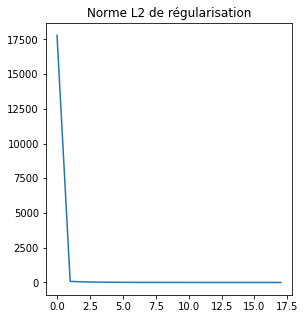

In [89]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [95]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.50719227808561
erreur SAM :  0.02161838135537371
erreur aSSIM :  0.09833675123545982


# $\lambda_1 = 1$, $\lambda_2 = 2$, et $\mu = 0.5$

In [15]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 2, 0.5, 5, 0.2)

iter =  1 fonction =  674.3204280620055
iter =  2 fonction =  286.39223736596733
iter =  3 fonction =  154.73541354331525
iter =  4 fonction =  115.9036791099397
iter =  5 fonction =  56.228133317249174
iter =  6 fonction =  33.63306916304527
iter =  7 fonction =  18.136841467502016
iter =  8 fonction =  15.330068446460878
iter =  9 fonction =  10.50923546376271
iter =  10 fonction =  8.025927697556329
iter =  11 fonction =  6.330915713847546
iter =  12 fonction =  4.950268016099455
iter =  13 fonction =  3.8475480426449398
iter =  14 fonction =  3.213820988463053
iter =  15 fonction =  2.5393257182144104
iter =  16 fonction =  2.1272156848299795
iter =  17 fonction =  1.7857692071555429
iter =  18 fonction =  1.5261169248201898
iter =  19 fonction =  1.3196681594501587
iter =  20 fonction =  1.1921842976313894
iter =  21 fonction =  1.075411718493223
iter =  22 fonction =  1.0029634559214782
iter =  23 fonction =  0.9066111727597723
iter =  24 fonction =  0.9261507035982406
iter =  25

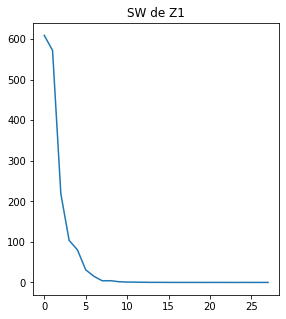

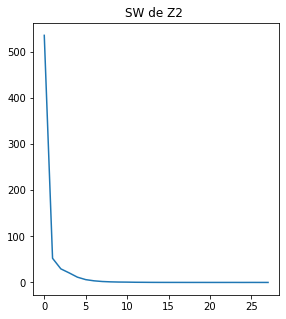

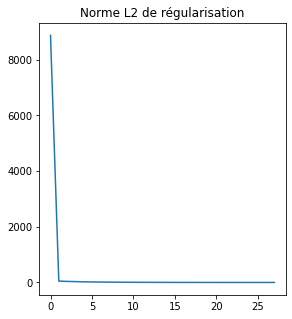

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


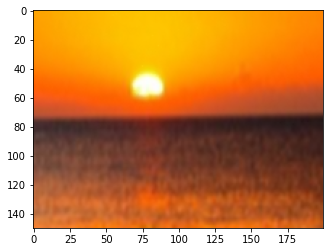

In [17]:
plt.imshow(X)

In [18]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.49134860628456
erreur SAM :  0.021995500662266406
erreur aSSIM :  0.09916411164210348
